<a href="https://colab.research.google.com/github/balavinaithirthan/CancerDrugResponse2DCNN/blob/main/Original_2D_CDR_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Copy data files from google drive to a local folder

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
base_folder = "./sample_data/"
base_project_folder = base_folder + "project/"

In [ ]:
# copy the zip file to the sample_data folder
!cp "drive/My Drive/2DCDRCNN/projectdata.zip" ./sample_data/
!cp "drive/My Drive/2DCDRCNN/R2.py" .

Unzip the data files into a folder

In [ ]:

from zipfile import ZipFile 
  
# specifying the zip file name 
file_name = base_folder + "projectdata.zip"
  
# opening the zip file in READ mode 
with ZipFile(file_name, 'r') as zip: 
    # printing all the contents of the zip file 
    zip.printdir() 
  
    # extracting all the files 
    print('Extracting all the files now...') 
    zip.extractall() 
    print('Done!') 

File Name                                             Modified             Size
sample_data/project/data.csv                   2020-11-03 02:38:18      8288978
sample_data/project/cells/HSC-4.csv            2020-11-03 02:39:58        18473
sample_data/project/cells/TYK-nu.csv           2020-11-03 02:39:58        18202
sample_data/project/cells/NCI-H1876.csv        2020-11-03 02:39:58        14882
sample_data/project/cells/DK-MG.csv            2020-11-03 02:39:58        14667
sample_data/project/cells/NCI-H196.csv         2020-11-03 02:39:58        14712
sample_data/project/cells/SK-MEL-3.csv         2020-11-03 02:39:58        14847
sample_data/project/cells/NCI-H2066.csv        2020-11-03 02:39:58        14866
sample_data/project/cells/MDA-MB-468.csv       2020-11-03 02:39:58        14847
sample_data/project/cells/RKN.csv              2020-11-03 02:39:58        14656
sample_data/project/cells/SW837.csv            2020-11-03 02:39:58        14783
sample_data/project/cells/NCI-H1781.csv 

Load and prepare data

In [ ]:
import pandas as pd
# load the drug and gene expression data set 
drug_gene_expression_dataset = pd.read_csv("sample_data/project/data.csv")


In [ ]:
import numpy as np

# load onehot enencoding of all drugs
onehot_encoded_drug_list = {}
# load the normailized gene expression of all drugs
normailized_gene_expression_list = {}
for item in drug_gene_expression_dataset.iterrows() :
  drug_name = item[1]['drug names']
  cell_name = item[1]['cell names']
  if (drug_name not in onehot_encoded_drug_list) :
    onehot_encoded_drug = pd.read_csv(drug_name, header=None, dtype=np.float64).to_numpy()
    onehot_encoded_drug_list[drug_name] =  np.reshape(onehot_encoded_drug, [188,28])
  if (cell_name not in normailized_gene_expression_list) :
    normailized_gene_expression = pd.read_csv(cell_name, header=None, dtype=np.float64).to_numpy()
    normailized_gene_expression_list[cell_name] = normailized_gene_expression.flatten()
print(len(normailized_gene_expression_list))
print(len(onehot_encoded_drug_list))

447
223


In [ ]:
#create a feature list consisting of onehot drug representation, normailized gene expression and ic50 target value
onehot_encoded_drug_feature_list = []
normailized_gene_expression_feature_list = []
ic50_target_list = []
for item in drug_gene_expression_dataset.iterrows() :
  drug_name = item[1]['drug names']
  cell_name = item[1]['cell names']
  ic50s = item[1]['ic50']
  normailized_gene_expression_feature_list.append(normailized_gene_expression_list[cell_name])
  onehot_encoded_drug_feature_list.append(onehot_encoded_drug_list[drug_name])
  ic50_target_list.append(ic50s)
onehot_encoded_drug_feature = np.stack( onehot_encoded_drug_feature_list, axis=0 )
normailized_gene_expression_feature = np.stack( normailized_gene_expression_feature_list, axis=0 )
ic50s = np.asarray(ic50_target_list)
print(onehot_encoded_drug_feature.shape)
print(normailized_gene_expression_feature.shape)
print(ic50s.shape)

(80730, 188, 28)
(80730, 2500)
(80730,)


Create the model


In [ ]:
from keras.models import Sequential, Model, Input
from keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, Concatenate, Dropout
import tensorflow as tf
import numpy as np
import R2

onehot_encoded_drug_input = Input(shape=(188,28), dtype=tf.float32, name="onehot_encoded_drug_input")
d = Conv1D(filters=40, kernel_size=7, padding="same", activation="relu", use_bias=True, name="drug_cnn_layer_1")(onehot_encoded_drug_input)
d = MaxPooling1D(pool_size=3, strides=3, padding="same", name="drug_cnn_layer_2")(d)
d = Conv1D(  filters=80, kernel_size=7, padding="same", activation="relu", use_bias=True, name="drug_cnn_layer_3")(d)
d = MaxPooling1D(pool_size=3, strides=3, padding="same", name="drug_cnn_layer_4")(d)
d = Conv1D(  filters=60, kernel_size=7, padding="same", activation="relu", use_bias=True, name="drug_cnn_layer_5")(d)
d = MaxPooling1D(pool_size=3, strides=3, padding="same", name="drug_cnn_layer_6")(d)

normailized_gene_expression_input = Input(shape=(2500,1), name="normailized_gene_expression_input")
g = Conv1D(filters=40, kernel_size=7, padding="same", activation="relu", use_bias=True, name="gene_expression_cnn_layer_1")(normailized_gene_expression_input)
g = MaxPooling1D(pool_size=3, strides=3, padding="same", name="gene_expression_cnn_layer_2")(g)
g = Conv1D(  filters=80, kernel_size=7, padding="same", activation="relu", use_bias=True, name="gene_expression_cnn_layer_3")(g)
g = MaxPooling1D(pool_size=3, strides=3, padding="same", name="gene_expression_cnn_layer_4")(g)
g = Conv1D(  filters=60, kernel_size=7, padding="same", activation="relu", use_bias=True, name="gene_expression_cnn_layer_5")(g)
g = MaxPooling1D(pool_size=3, strides=3, padding="same", name="gene_expression_cnn_layer_6")(g)

fcn = Concatenate(1, name="combine_drug_and_gene_expression_cnns")([d, g])
fcn = Flatten(name="fcn_layer_1")(fcn)
fcn = Dense(1024, activation='relu',use_bias=True, name="fcn_layer_2")(fcn)
fcn = Dropout(0.2, name="fcn_layer_3")(fcn)
fcn = Dense(1024, activation='relu',use_bias=True, name="fcn_layer_4")(fcn)
fcn = Dropout(0.2, name="fcn_layer_5")(fcn)
fcn_output = Dense(1,  activation='sigmoid',use_bias=True, name="fcn_output_layer_6")(fcn)

model = Model( name="2d_cdr_cnn",  
    inputs=([onehot_encoded_drug_input,normailized_gene_expression_input]),
    outputs=fcn_output
)


model.compile( optimizer='adam',
               loss="mean_squared_error",
               metrics=[tf.keras.metrics.RootMeanSquaredError(), R2.RSquare(), 'mae'])

model.summary()



Model: "2d_cdr_cnn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
onehot_encoded_drug_input (Inpu [(None, 188, 28)]    0                                            
__________________________________________________________________________________________________
normailized_gene_expression_inp [(None, 2500, 1)]    0                                            
__________________________________________________________________________________________________
drug_cnn_layer_1 (Conv1D)       (None, 188, 40)      7880        onehot_encoded_drug_input[0][0]  
__________________________________________________________________________________________________
gene_expression_cnn_layer_1 (Co (None, 2500, 40)     320         normailized_gene_expression_input
_________________________________________________________________________________________

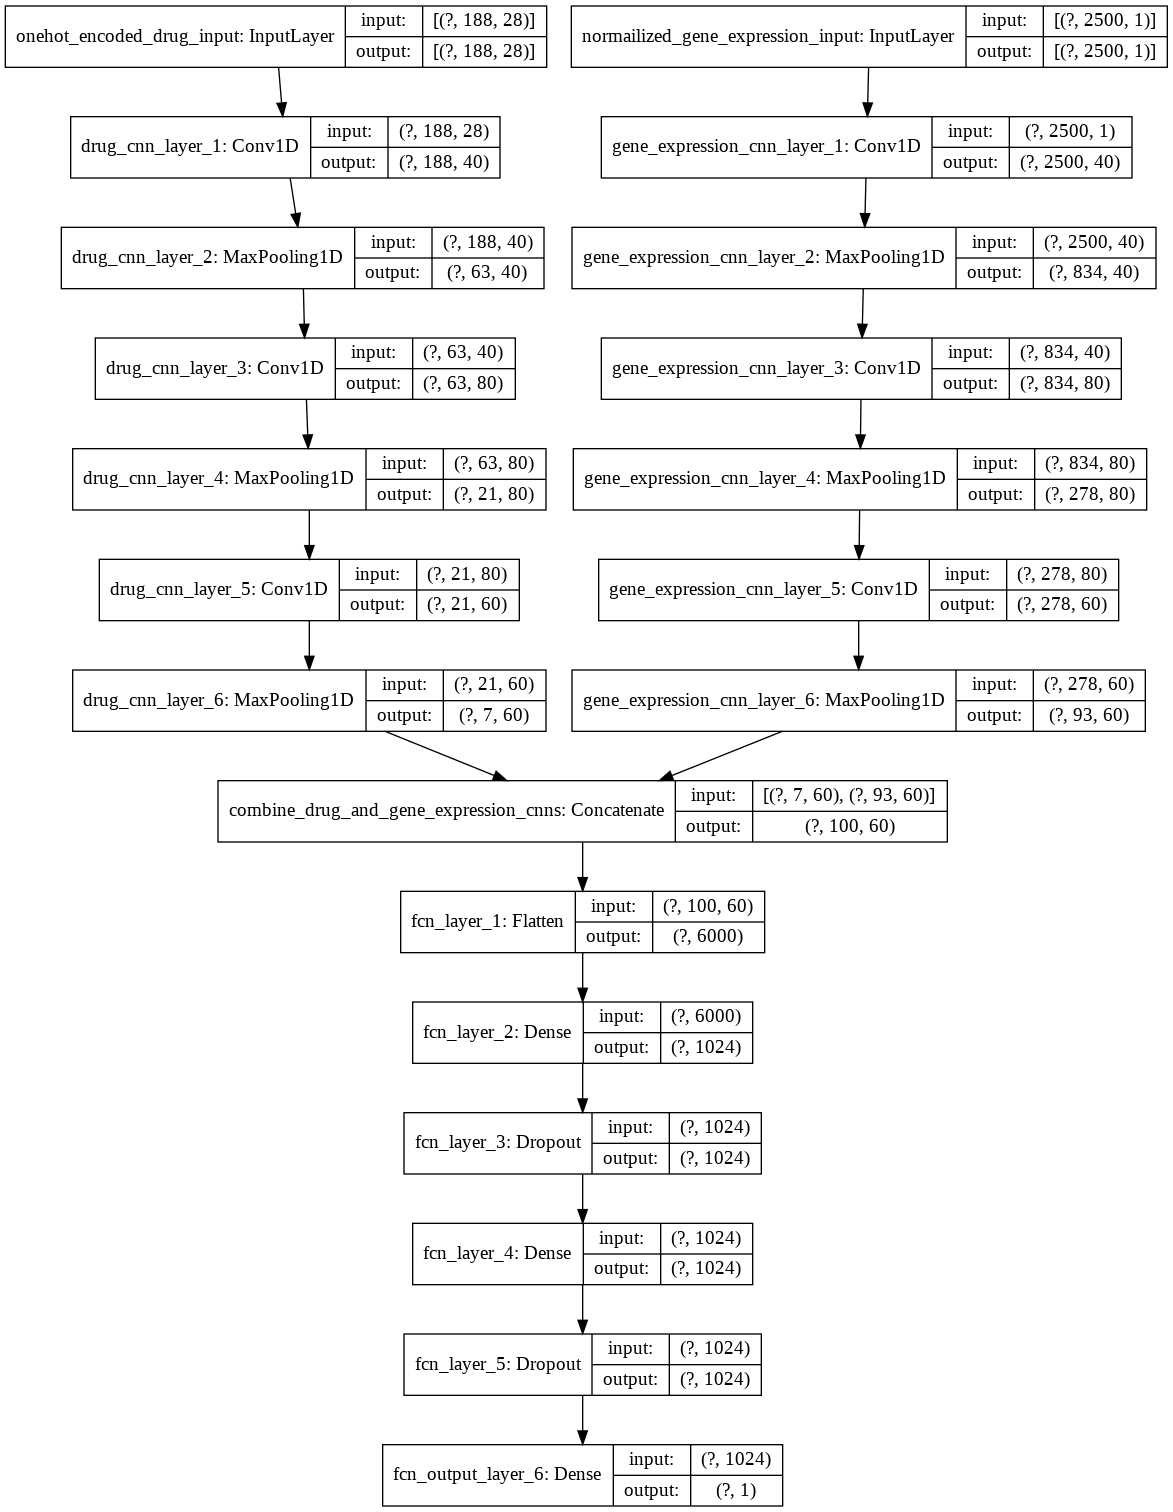

In [ ]:
tf.keras.utils.plot_model(model, "my_first_model_with_shape_info.png", show_shapes=True)

In [ ]:
model.fit(
    {"onehot_encoded_drug_input": onehot_encoded_drug_feature, "normailized_gene_expression_input": normailized_gene_expression_feature},
    {"fcn_output_layer_6": ic50s},
    epochs=15,
    validation_split=0.1,
    shuffle=True,
    batch_size=100,
    verbose=1
)

Epoch 1/15
727/727 [==============================] - 581s 799ms/step - loss: 0.0016 - root_mean_squared_error: 0.0403 - r_square: 0.6480 - mae: 0.0296 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0348 - val_r_square: 0.7363 - val_mae: 0.0266
Epoch 2/15
727/727 [==============================] - 583s 801ms/step - loss: 0.0011 - root_mean_squared_error: 0.0337 - r_square: 0.7535 - mae: 0.0255 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0341 - val_r_square: 0.7471 - val_mae: 0.0265
Epoch 3/15
727/727 [==============================] - 579s 796ms/step - loss: 0.0011 - root_mean_squared_error: 0.0324 - r_square: 0.7722 - mae: 0.0244 - val_loss: 9.7875e-04 - val_root_mean_squared_error: 0.0313 - val_r_square: 0.7872 - val_mae: 0.0235
Epoch 4/15
727/727 [==============================] - 576s 792ms/step - loss: 9.8360e-04 - root_mean_squared_error: 0.0314 - r_square: 0.7869 - mae: 0.0236 - val_loss: 9.5063e-04 - val_root_mean_squared_error: 0.0308 - val_r_square: 0.7933 - val_